In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((128,128))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128))
])

In [4]:
train_dataset = ImageFolder('/Users/subhashmedipalli/Downloads/Github Projects/Deeplearning_Project_DataSets/clouds/clouds_train',
                            transform=train_transforms)
cloud_train_dataloader = DataLoader(train_dataset, batch_size = 1, shuffle=True)

In [5]:
test_dataset = ImageFolder('/Users/subhashmedipalli/Downloads/Github Projects/Deeplearning_Project_DataSets/clouds/clouds_test', 
                           transform = test_transforms)
cloud_test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

In [7]:
image, label = next(iter(cloud_train_dataloader))
print(image.shape)

torch.Size([1, 3, 128, 128])


In [8]:
image = image.squeeze().permute(1,2,0)
print(image.shape)

torch.Size([128, 128, 3])


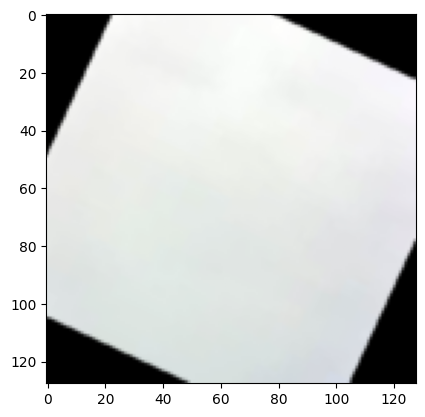

In [10]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.show()

In [11]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3,32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )
        self.classifier = nn.Linear(64*32*32, num_classes)
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [13]:
net = Net(num_classes=7)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

net.train()
for epoch in range(30):
    running_loss = 0
    for images, labels in cloud_train_dataloader:
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss/len(cloud_train_dataloader)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")
print('Training Completed!')

Epoch 1, Loss: 2.5465
Epoch 2, Loss: 2.0282
Epoch 3, Loss: 2.3017
Epoch 4, Loss: 2.3644
Epoch 5, Loss: 1.8507
Epoch 6, Loss: 1.8534
Epoch 7, Loss: 2.6810
Epoch 8, Loss: 1.4341
Epoch 9, Loss: 1.7712
Epoch 10, Loss: 2.7424
Epoch 11, Loss: 1.4800
Epoch 12, Loss: 1.4047
Epoch 13, Loss: 2.2871
Epoch 14, Loss: 2.2648
Epoch 15, Loss: 1.2199
Epoch 16, Loss: 1.1937
Epoch 17, Loss: 1.4284
Epoch 18, Loss: 3.8598
Epoch 19, Loss: 1.4136
Epoch 20, Loss: 1.1019
Epoch 21, Loss: 1.4835
Epoch 22, Loss: 1.2807
Epoch 23, Loss: 2.3730
Epoch 24, Loss: 1.3373
Epoch 25, Loss: 1.3820
Epoch 26, Loss: 1.9234
Epoch 27, Loss: 1.3053
Epoch 28, Loss: 1.2921
Epoch 29, Loss: 1.3223
Epoch 30, Loss: 2.0014
Training Completed!


In [14]:
from torchmetrics import  Precision,Recall

metric_precision = Precision(task='multiclass', num_classes=7, average='macro')
metric_recall = Recall(task='multiclass', num_classes=7, average='macro')

net.eval()
with torch.no_grad():
    for images, labels in cloud_test_dataloader:
        outputs = net(images)
        _, pred = torch.max(outputs, 1)
        metric_precision(pred, labels)
        metric_recall(pred, labels)
precision = metric_precision.compute()
recall = metric_recall.compute()

In [15]:
print(f"Precision: {precision*100:.2f}")
print(f"Recall: {recall*100:.2f}")

Precision: 26.99
Recall: 41.59


In [17]:
# Define precision metric
metric_precision = Precision(
    task='multiclass', num_classes=7, average=None
)

net.eval()
with torch.no_grad():
    for images, labels in cloud_test_dataloader:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
precision = metric_precision.compute()

# Get precision per class
precision_per_class = {
    k: precision[v].item()
    for k, v 
    in test_dataset.class_to_idx.items()
}
print(precision_per_class)

{'cirriform clouds': 0.0, 'clear sky': 0.6037735939025879, 'cumulonimbus clouds': 0.4761904776096344, 'cumulus clouds': 0.3333333432674408, 'high cumuliform clouds': 0.28823530673980713, 'stratiform clouds': 0.0, 'stratocumulus clouds': 0.1875}
